In [0]:
import matplotlib.pyplot as plt

In [0]:
from keras import models, backend
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, \
    BatchNormalization, Concatenate, Activation

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc=0)

def plot_acc(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)


def save_history_history(fname, history_history, fold=''):
    np.save(os.path.join(fold, fname), history_history)


def load_history_history(fname, fold=''):
    history_history = np.load(os.path.join(fold, fname)).item(0)
    return history_history


Model

In [0]:
class UNET(models.Model):
    def __init__(self, original_shape, num_channels):
        num_img_channels = 3 if backend.image_data_format() == 'channels_last' else 1 #채널이 있는 shape순서
        
        def conv(x, num_filters, mp_flag=True):
            x = MaxPooling2D(pool_size=(2,2), padding='same')(x) if mp_flag else x
            x = Conv2D(num_filters, (3,3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(num_filters, (3,3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x
        
        def deconv_unet(x, encoded, num_filters):
            '''
            x의 (w,h)를 두배로 upsampling하고 encoded를 붙인다.
            '''
            x = UpSampling2D(size=(2,2))(x)
            print("x.shape=", x.shape, " encoded.shape=", encoded.shape) #x.shape(?, 16, 16, 64) encoded.shape(?, 16, 16, 32)
            x = Concatenate(axis = num_img_channels)([x, encoded])
            print("concatenated x.shape=", x.shape)
            x = Conv2D(num_filters, (3,3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(num_filters, (3,3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x
        
        #input
        original = Input(shape=original_shape)
        print("original.shape =", original.shape) #(?, 32, 32, 1)
        
        '''
        encode : c1 -> c2 -> encoded
        decode : conv2D(deconv(deconv(encoded + c2) + c1))
        '''
        
        #encoding
        c1 = conv(original, 16, mp_flag=False) # maxpooling 안하므로 size변경 없이 channel만 변경
        print("c1.shape =", c1.shape) #(?, 32, 32, 16)
        c2 = conv(c1, 32) # (w,h)가 각각 반씩 준다.
        print("c2.shape =", c2.shape) #(?, 16, 16, 32)
        
        #encoder
        encoded = conv(c2, 64) # (w, h)가 반씩 준다.
        print("encoded.shape =", encoded.shape) #(?, 8, 8, 64) 각각 1/4로 줄었다.
        
        #decoding
        '''
        
        '''
        x = deconv_unet(encoded, c2, 32) #encoded=(?, 8, 8, 64), c2=(?, 16, 16, 32)
        print("x.shape(1) =", x.shape) #(?, 16, 16, 32)
        x = deconv_unet(x, c1, 16) #x=(?, 16, 16, 32), c1=(?, 32, 32, 16)
        print("x.shape(2) =", x.shape) #(?, 32, 32, 16)
        
        # 이미 (w, h)는 위에서 동일 크기가 되었고, 아래에서 channel수만 원래 값으로 변경한다.
        decoded = Conv2D(filters=num_channels, kernel_size=(3,3), activation='sigmoid', padding='same')(x)
        print("decoded.shape=",decoded.shape) #(?, 32, 32, 3)
        
        super().__init__(original, decoded)
        self.compile(optimizer = 'adadelta', loss='mse')
            

데이터 불러오기

In [0]:
from keras import datasets, utils

class DATA():
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        
        #데이터가 너무많아 느림. 10000 2500정도로 날리세
        x_train = x_train[:10000, ...]
        y_train = y_train[:10000, ...]
        x_test = x_test[:2500, ...]
        y_test = y_test[:2500, ...]
        
        print("data shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        print("x_train.ndim=", x_train.ndim)
        if x_train.ndim == 4:
            if backend.image_data_format() == 'channels_first':
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
        
        print("x_train.shape[1:]", x_train.shape[1:])
            
        in_ch = n_ch if in_ch is None else in_ch
        
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
        
        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else: #channels_last
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]
                
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        def RGB2RG(x_train_out, x_test_out, fmt):
            '''
            RGB에서 RG까지만 꺼내서 2ch 이미지를 리턴
            '''
            if fmt == 'channels_first':
                x_train_in = x_train_out[:, :2]
                x_test_in = x_test_out[:, :2]
            else:
                x_train_in = x_train_out[..., :2]
                x_test_in = x_test_out[..., :2]
            return x_train_in, x_test_in
        
        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)
            
        fmt = backend.image_data_format()
        if in_ch == 1 and n_ch == 3: # 입력이 흑백(1ch)
            x_train_in = RGB2Gray(x_train_out, fmt)
            x_test_in = RGB2Gray(x_test_out, fmt)
        elif in_ch == 2 and n_ch == 3: # 입력이 RG(2ch)
            x_train_in, x_test_in = RGB2RG(x_train_out, x_test_out, fmt)
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out
        '''
        x_train_in : 흑백 입력 이미지
        x_train_out : x_train에 reshape만 맞춤
        '''
        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch


In [0]:
######################################
# UNET 검증 및 동작 확인           
######################################

import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import minmax_scale

def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs_org = unet.predict(x_test_in)
    decoded_imgs = decoded_imgs_org
    
    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1,3).swapaxes(1, 2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1,3).swapaxes(1,2)
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
        elif data.in_ch == 2:
            print(x_test_out.shape)
            x_test_in_tmp =- np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1,3).swapaxes(1,2)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
        else:
            x_test_in = x_test_in.swapaxes(1,3).swapaxes(1,2)            
    else:        
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
            
    n = 10
    plt.figure(figsize=(20 ,6))
    for i in range(n):
        ax = plt.subplot(3, n ,i + 1)
        if x_test_in.ndim < 4:
            plt.imshow(x_test_in[i], cmap='gray')
        else:
            plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()
            

In [0]:
def main(in_ch = 1, epochs=10, batch_size=512, fig=True):
    #training & validation:
    
    data = DATA(in_ch=in_ch)
    print("input_shape : ", data.input_shape, "x_train_in.shape:", data.x_train_in.shape)
    unet = UNET(data.input_shape, data.n_ch)
    
    history = unet.fit(data.x_train_in, data.x_train_out,
                      epochs=epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)
    print(history.history)
    if fig:
        plot_loss(history)
        show_images(data, unet)


input_shape :  (32, 32, 1) x_train_in.shape: (10000, 32, 32, 1)
original.shape = (?, 32, 32, 1)
c1.shape = (?, 32, 32, 16)
c2.shape = (?, 16, 16, 32)
encoded.shape = (?, 8, 8, 64)
x.shape= (?, 16, 16, 64)  encoded.shape= (?, 16, 16, 32)
concatenated x.shape= (?, 16, 16, 96)
x.shape(1) = (?, 16, 16, 32)
x.shape= (?, 32, 32, 32)  encoded.shape= (?, 32, 32, 16)
concatenated x.shape= (?, 32, 32, 48)
x.shape(2) = (?, 32, 32, 16)
decoded.shape= (?, 32, 32, 3)
Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 11s 1ms/step - loss: 0.0327 - val_loss: 0.0202
Epoch 2/2
8000/8000 [==============================] - 2s 214us/step - loss: 0.0188 - val_loss: 0.0190
{'val_loss': [0.02023861348628998, 0.019019326969981192], 'loss': [0.03271826550364494, 0.018827924460172653]}


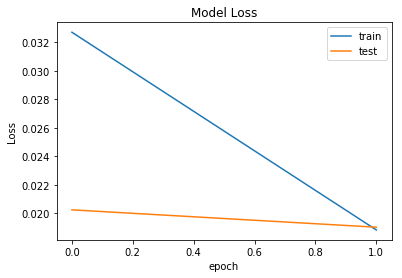

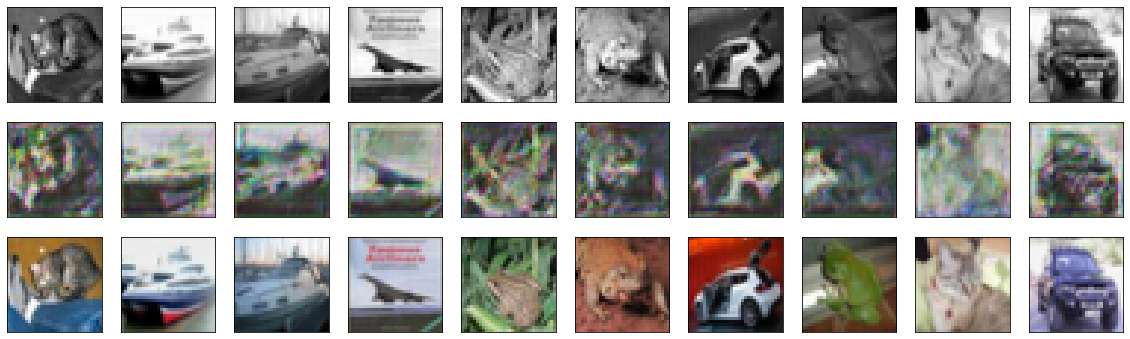

In [62]:
if __name__ == '__main__':
    main(in_ch=1, epochs=2, batch_size=512, fig=True)